In [131]:
import audio_functions as af
from audio_file_iterator import iter as audio_file_iterator
import plot
import soundfile as sf
import pandas as pd
import numpy as np
import os
import librosa
import librosa.feature

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preprocessing of the audio files
Perform some steps to preprocess audio files and convert them into a feature vector
## Preprocess converted WAV files
### Read in the audio data from the directory structure
read in the data and store the audio content together with the directory path to save the information of the associatated class label

In [132]:
loaded_audio_files, dirs = zip(*[ (sf.read(audio_file_name, dtype='float32'), os.path.dirname(audio_file_name)) for audio_file_name in audio_file_iterator()])

Processing genre directory '06 Deep House'
   Processed 360 files          
Processing genre directory '09 Disco Funk'
   Processed 298 files          
Processing genre directory '12 Chinese Traditional'
   Processed 300 files          
Processing genre directory '15 Reggaeton Pop'
   Processed 322 files          
Processing genre directory 'Keyboard Collection'
   Processed 164 files          


## One Hot Encoding
Get the directory names form the data folder, which are used to identify the name of the classes and encode the feature labels using a One-Hot-Encoding.

In [133]:
from sklearn.preprocessing import OneHotEncoder

class_idx = 0
# remove leading directory name
sliced_dir_names = list(map(lambda s: s.replace('wav_data\\', ''), dirs))

ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(np.array(sliced_dir_names).reshape(-1, 1))

cats = ohe.categories_[0]
print("Categories ({n}):".format(n=len(cats)))
[print("   ", cat) for cat in cats]

ohe_labels_array = ohe_labels.toarray()

Categories (5):
    06 Deep House
    09 Disco Funk
    12 Chinese Traditional
    15 Reggaeton Pop
    Keyboard Collection


Save the label vector and the class mapping to seperate files

In [134]:
np.save('data/labels.npy', ohe_labels_array)
with open('data/class_label_index_mapping.txt', 'w') as f:
    [ f.write(c + ':' + str(i) + '\n') for i, c in enumerate(cats) ]

### perform sequential several preprocessing steps
 - slice audio to 3s unit length snippets (zero-padded if shorter)
 - convert track to mono audio
 - downsample audio files to 4kBit

First, all samples are cut into a unit time length and stored in a list of tuples, where each list elements is a tuple, consisting of a 3-second audio snippet and its samplerate

In [136]:
unit_length = 3000

to_multi_slices = lambda t: (af.multi_slice_to_length(t[0], t[1], unit_length), t[1])

unit_length_audio = map(to_multi_slices, loaded_audio_files)

unit_length_audio, sr = zip(*unit_length_audio)

unit_length_audio = [item for sublist in unit_length_audio for item in sublist]

define and prepare preprocessing steps with the corresponding parameters:

In [137]:
downsample_rate = 4000

to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])
resample = lambda t : (af.resample(t[0], t[1], downsample_rate), t[1])

preprocessing_steps = [
    to_mono,
    resample
]

features_preprocessed = unit_length_audio
for step in preprocessing_steps:
    features_preprocessed = map(step, features_preprocessed)

perform preprocessing from generator-pipline and extract the features as an numpy-array

In [138]:
features, _ = zip(*features_preprocessed)
feature_array = np.vstack(features)

In [184]:
from save_utils import save_numpy_array_sliced

print("Feature array uses {s:.2f} MB of disc space".format(s=feature_array.nbytes/1024/1024))

save_numpy_array_sliced('preprocessed_data', feature_array)

Feature array uses 186.22 MB of disc space
Saved slice to file preprocessed_data_1
Saved slice to file preprocessed_data_2
Saved slice to file preprocessed_data_3


Plot a random example of a waveform from the preprocessed data to verify the preprocessing steps

Plot audio sample 3437
Dimensions: (12000,)


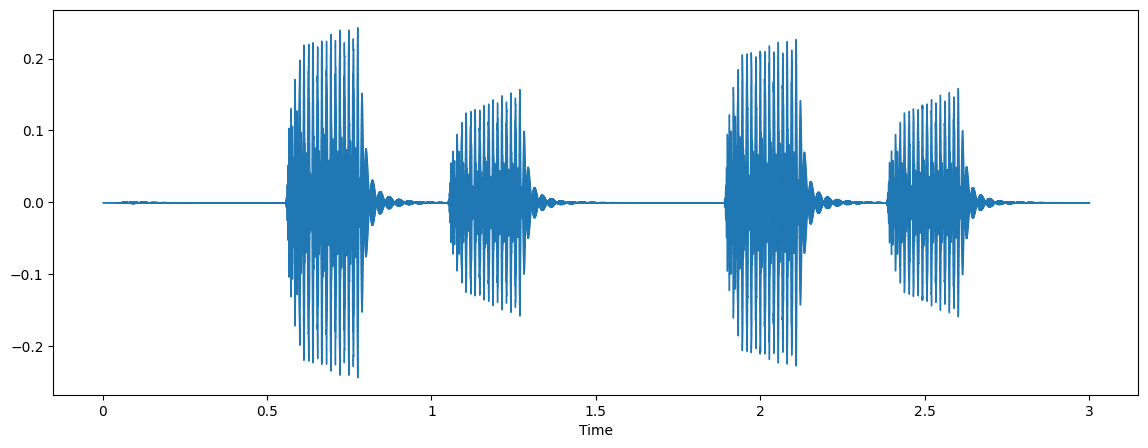

In [142]:
from random import randint

x = randint(0, len(feature_array)-1)
random_feature = feature_array[x, :]

print("Plot audio sample", x)
plot.plot_waveform(random_feature, downsample_rate)

print("Dimensions:", random_feature.shape)

# Check for correct sample rate, length and for mono-track
assert random_feature.shape[0] == unit_length*downsample_rate/1000 and len(random_feature.shape) == 1

### Store the data
Save the data in numpy format  
Summary:
- samples of 3 seconds length
- sample rate of 4kHz
- mono audio
- samples whose length was above 3 seconds were sliced into multiple snippets, with the last snippet being zero-padded in the end 

In [64]:
get_melspectogram = lambda t: (librosa.feature.melspectrogram(y=t[0], sr=t[1], n_mels=64, fmax=20000, hop_length=256), t[1])
get_spectogram_db = lambda t : (librosa.power_to_db(np.abs(librosa.feature.melspectrogram(y=t[0], sr=t[1], n_fft=32, hop_length=256, power=2.0, n_mels=64))), t[1])

features_spectogram = map(get_melspectogram, features)
features_spectogram, sr = zip(*features_spectogram)
features = np.vstack(features_spectogram)

20


(20, 44100)

In [ ]:
plot.plot_melspectogram(features[0], sr[0], fmax = 20000)